Author: Nik Alleyne <br>
Author Blog: https://www.securitynik.com <br>
Author GitHub:github.com/securitynik <br>
Author Books: [  <br>
                "https://www.amazon.ca/Learning-Practicing-Leveraging-Practical-Detection/dp/1731254458/",  <br>
                "https://www.amazon.ca/Learning-Practicing-Mastering-Network-Forensics/dp/1775383024/" <br>
            ] <br>

## 13. Beginning Deep Learning - Anomaly Detection with AutoEncoders - PyTroch

This post is part of my beginning machine learning series.  <br>
The series includes the following: <br>

01 - Beginning Numpy <br>
02 - Beginning Tensorflow  <br>
03 - Beginning PyTorch <br>
04 - Beginning Pandas <br>
05 - Beginning Matplotlib <br>
06 - Beginning Data Scaling <br>
07 - Beginning Principal Component Analysis (PCA) <br>
08 - Beginning Machine Learning Anomaly Detection - Isolation Forest and Local Outlier Factor <br>
09 - Beginning Unsupervised Machine Learning - Clustering - K-means and DBSCAN <br>
10 - Beginning Supervise Learning - Machine Learning - Logistic Regression, Decision Trees and Metrics <br>
11 - Beginning Linear Regression - Machine Learning <br>
12 - Beginning Deep Learning - Anomaly Detection with AutoEncoders, Tensorflow <br>
13 - Beginning Deep Learning - Anomaly Detection with AutoEncoders, PyTroch <br>
14 - Beginning Deep Learning, - Linear Regression, Tensorflow <br>
15 - Beginning Deep Learning, - Linear Regression, PyTorch <br>
16 - Beginning Deep Learning, - Classification, Tensorflow <br>
17 - Beginning Deep Learning, - Classification, Pytorch <br>
18 - Beginning Deep Learning, - Classification - regression - MIMO - Functional API Tensorflow <br> 
19 - Beginning Deep Learning, - Convolution Networks - Tensorflow <br>
20 - Beginning Deep Learning, - Convolution Networks - PyTorch <br>
21 - Beginning Regularization - Early Stopping, Dropout, L2 (Ridge), L1 (Lasso) <br>
23 - Beginning Model TFServing <br>

But conn.log is not the only file within Zeek. Let's build some models for DNS and HTTP logs. <br>
I choose unsupervised, because there are no labels coming with these data. <br>

24 - Continuing Anomaly Learning - Zeek DNS Log - Machine Learning <br>
25 - Continuing Unsupervised Learning - Zeek HTTP Log - Machine Learning <br>

This was a specific ask by someone in one of my class. <br>
26 - Beginning - Reading Executables and Building a Neural Network to make predictions on suspicious vs suspicious  <br><br>

With 26 notebooks in this series, it is quite possible there are things I could have or should have done differently.  <br>
If you find any thing, you think fits those criteria, drop me a line. <br>

In [1]:
# import some libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# In the notebooks on Pandas, Matplotlib and Scaling
# we loaded our dataset such as
df_conn = pd.read_csv(r'df_conn_with_labels.csv', index_col=0)
df_conn

,id.resp_p,duration,orig_bytes,resp_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label
1,48798,0.000000,0,0,0,0,0,0,0
2,48804,0.000000,0,0,0,0,0,0,0
4,27761,0.000000,0,0,0,0,0,0,0
5,8888,0.053276,208,976,6,528,6,1296,0
6,8888,0.383646,227,692369,202,10739,117,240893,0
...,...,...,...,...,...,...,...,...,...
4430183,9200,0.000051,0,0,1,52,1,40,0
4430184,9200,0.000023,0,0,0,0,1,40,0
4430185,9200,0.000005,0,0,0,0,1,40,0
4430186,9200,0.000005,0,0,0,0,1,40,0


This file represents Zeek (formerly Bro) connection log - conn.log`. <br>
Zeek is a framework used for Network Security Monitoring.  <br>
This entire series is based on using Zeek's data.  <br>
The majority of the notebooks use the conn.log <br>
You can learn more about Zeek here:
   
    https://zeek.org/

Alternatively, come hang out with us in the:
SANS SEC595: Applied Data Science and Machine Learning for Cybersecurity Professionals

        https://www.sans.org/cyber-security-courses/applied-data-science-machine-learning/ OR

SEC503 SEC503: Network Monitoring and Threat Detection In-Depth

        https://www.sans.org/cyber-security-courses/network-monitoring-threat-detection/


Here are also some blog posts on using Zeek for security monitoring
Installing Zeek: 

        https://www.securitynik.com/2020/06/installing-zeek-314-on-ubuntu-2004.html

Detecting PowerShell Empire Usage: 

        https://www.securitynik.com/2022/02/powershell-empire-detection-with-zeek.html

Detecting Log4J Vulnerability Exploitation: 

        https://www.securitynik.com/2021/12/continuing-log4shell-zeek-detection.html

In [3]:
# Drop the port column
df_conn = df_conn.drop(columns=['id.resp_p'], inplace=False)
df_conn

,duration,orig_bytes,resp_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label
1,0.000000,0,0,0,0,0,0,0
2,0.000000,0,0,0,0,0,0,0
4,0.000000,0,0,0,0,0,0,0
5,0.053276,208,976,6,528,6,1296,0
6,0.383646,227,692369,202,10739,117,240893,0
...,...,...,...,...,...,...,...,...
4430183,0.000051,0,0,1,52,1,40,0
4430184,0.000023,0,0,0,0,1,40,0
4430185,0.000005,0,0,0,0,1,40,0
4430186,0.000005,0,0,0,0,1,40,0


In [4]:
# Looking at above, we see a number of records with 0s. 
# These will add no value to our learning process
# I know you might be saying, why didn't we fix these earlier. 
# Good question, we are learning (pun intended) as we go along
# Besides, you learn more about your data as you work with it
# Or as it is said, if you interrogate the data long enough, it will confess
#   https://quoteinvestigator.com/2021/01/18/confess/
# Let's find all those records and drop them
# Reference: https://stackoverflow.com/questions/13851535/how-to-delete-rows-from-a-pandas-dataframe-based-on-a-conditional-expression
df_conn = df_conn.drop(df_conn[(df_conn.duration == 0 ) & (df_conn.orig_bytes == 0 ) 
                               & (df_conn.resp_bytes == 0 ) & (df_conn.orig_pkts == 0 )  
                               & (df_conn.orig_ip_bytes == 0 ) & (df_conn.resp_pkts == 0 ) 
                               & (df_conn.resp_ip_bytes == 0 )].index)
df_conn

,duration,orig_bytes,resp_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes,label
5,0.053276,208,976,6,528,6,1296,0
6,0.383646,227,692369,202,10739,117,240893,0
7,0.054294,208,977,6,528,6,1297,0
8,0.424980,227,791633,176,9387,174,367737,0
9,0.272567,227,406607,171,9127,71,169939,0
...,...,...,...,...,...,...,...,...
4430183,0.000051,0,0,1,52,1,40,0
4430184,0.000023,0,0,0,0,1,40,0
4430185,0.000005,0,0,0,0,1,40,0
4430186,0.000005,0,0,0,0,1,40,0


In [5]:
# Interesting, after removing those records where the rows had all 0s, our dataset is now 207,608 records
# Keep in mind the original normal dataset was over 4.4 million records.
# This is a good reduction of useless records

In [6]:
# As always analyze our data before looking into any Machine or in this case Deep Learning algorithms
# Extract all the records where the labels are 0 and mark those as normal
# These will be used to train our autoencoder
df_normal = df_conn[df_conn.label == 0]
df_normal_labels = df_conn[df_conn.label == 0].values[:, -1]
df_normal = df_normal.drop(columns=['label'], inplace=False)
df_normal

,duration,orig_bytes,resp_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
5,0.053276,208,976,6,528,6,1296
6,0.383646,227,692369,202,10739,117,240893
7,0.054294,208,977,6,528,6,1297
8,0.424980,227,791633,176,9387,174,367737
9,0.272567,227,406607,171,9127,71,169939
...,...,...,...,...,...,...,...
4430183,0.000051,0,0,1,52,1,40
4430184,0.000023,0,0,0,0,1,40
4430185,0.000005,0,0,0,0,1,40
4430186,0.000005,0,0,0,0,1,40


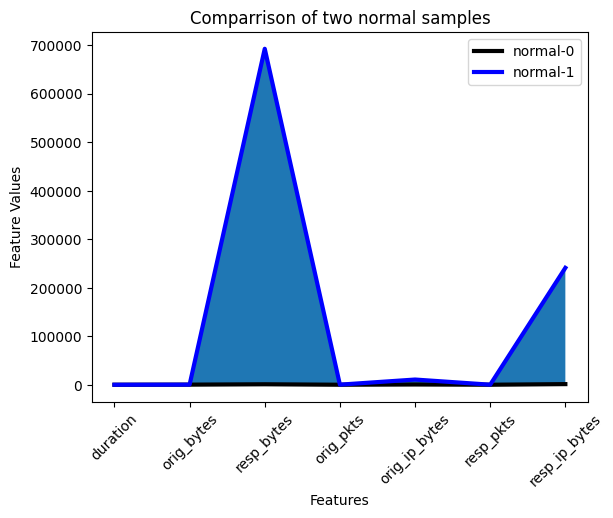

In [7]:
# Plotting two of the normal sample data points, to see what the data looks like
plt.title('Comparrison of two normal samples')
plt.plot(df_normal.values[0, : ], label='normal-0', c='black', lw=3)
plt.plot(df_normal.values[1, : ], label='normal-1', c='b', lw=3)
plt.fill_between(x=np.arange(start=0,stop=7, step=1), y1=df_normal.values[0, : ], y2=df_normal.values[1, : ] )
plt.xlabel(xlabel='Features')
plt.xticks(np.arange(start=0, stop=7, step=1), ['duration', 'orig_bytes', 'resp_bytes', \
                                                'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes'], rotation=45)
plt.ylabel(ylabel='Feature Values')
plt.legend(loc='best')
plt.show()

In [8]:
# With an understanding of what the first two normal data points looks like
# Extract all the records where the labels are 1 and mark those as suspicious
# These will be used to understand our autoencoder performance against suspicious traffic
# The expectation is the autonencoder will have a higher reconstruction error for those suspicious records
df_suspicious = df_conn[df_conn.label == 1 ]
df_suspicious = df_suspicious.drop(columns=['label'], inplace=False)
df_suspicious

,duration,orig_bytes,resp_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
5982,5.932275,15759454,645,7798,11593818,10588,428317
51574,107.685110,1567276,0,14,133416,0,0
55611,217.387880,3213967,0,6,58430,0,0
115226,130.989500,2480118,362609,50,1595225,10,197593
115972,141.094380,3561386,1107090,60,3026679,33,982584
...,...,...,...,...,...,...,...
4032886,264.840360,1207114,451720,1,52,11,373114
4052768,7110.420400,1124942,16527,1873,1251154,1695,112731
4070183,1079.268100,1767062,0,52,1586878,0,0
4192109,213.562450,1107362,186663,1,52,5,159831


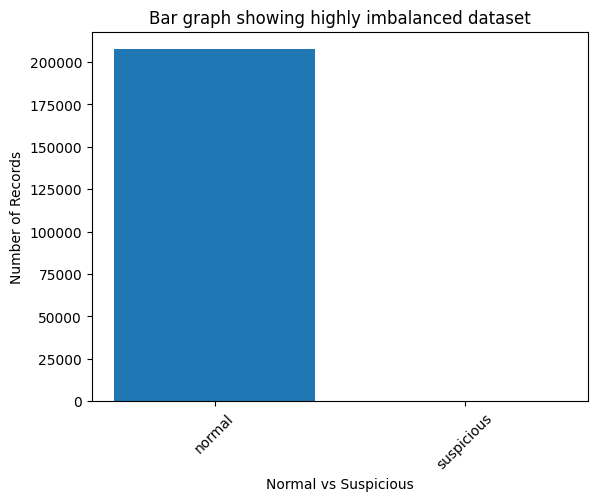

In [9]:
# The graph below shows this dataset is highly imbalanced.
# There is a significant disparity in the number of records
# As a result, using measures like accuracy is more than likely not the best approach, 
# to understand how well our eventual model has "learned"
# via the training data
plt.title('Bar graph showing highly imbalanced dataset')
plt.bar(x=['normal', 'suspicious'], height=[df_normal.shape[0], df_suspicious.shape[0]])
plt.ylabel(ylabel='Number of Records')
plt.xlabel(xlabel='Normal vs Suspicious')
plt.xticks(rotation=45)
plt.show()


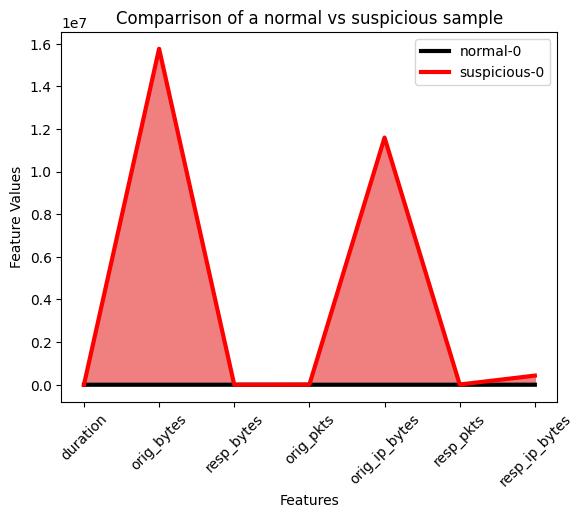

In [10]:
# Plotting a normal vs a suspicious sample
plt.title('Comparrison of a normal vs suspicious sample')
plt.plot(df_normal.values[0, : ], label='normal-0', c='black', lw=3)
plt.plot(df_suspicious.values[0, : ], label='suspicious-0', c='r', lw=3)
plt.fill_between(x=np.arange(start=0,stop=7, step=1), y1=df_normal.values[0, : ], 
                 y2=df_suspicious.values[0, : ], color='lightcoral')
plt.xlabel(xlabel='Features')
plt.xticks(np.arange(start=0, stop=7, step=1), ['duration', 'orig_bytes', 'resp_bytes', \
                                                'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes'], rotation=45)
plt.ylabel(ylabel='Feature Values')
plt.legend(loc='best')

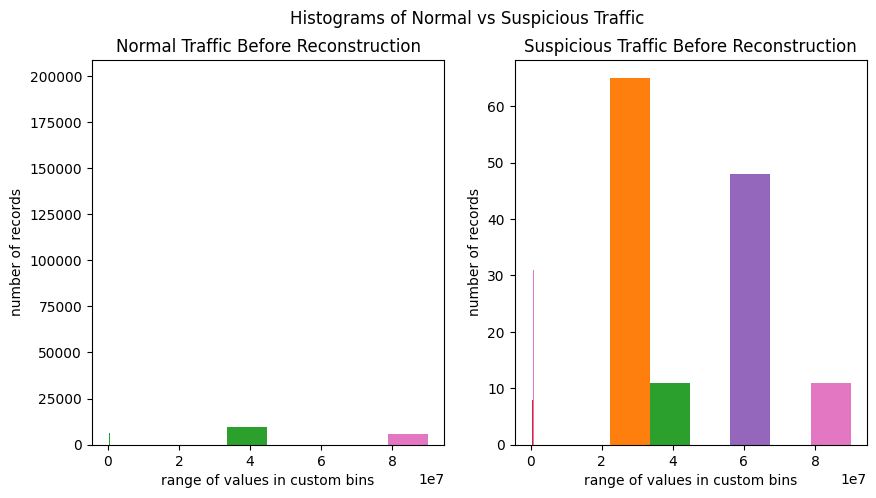

In [11]:
# What do we conclude from the normal vs suspicious activity?
# Duration, orig_bytes, orig_pkts, orig_ip_bytes all seems to be higher for the suspicious sample
# Comparing a histogram of the data
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5), sharex=True, sharey=False)

plt.suptitle('Histograms of Normal vs Suspicious Traffic')
ax[0].set_title('Normal Traffic Before Reconstruction')
ax[0].hist(df_normal, bins=[0, 1e2, 1e4, 1e6, 1e8])
ax[0].set_ylabel(ylabel='number of records')
ax[0].set_xlabel(xlabel='range of values in custom bins')

ax[1].set_title('Suspicious Traffic Before Reconstruction')
ax[1].hist(df_suspicious, bins=[0, 1e2, 1e4, 1e6, 1e8])
ax[1].set_ylabel(ylabel='number of records')
ax[1].set_xlabel(xlabel='range of values in custom bins')
plt.show()


In [12]:
# Definitely, there is a visible difference between the normal and suspicious traffic histogram
# Let's get some descriptive statistics on the two datasets
# Starting with the normal traffic
pd.options.display.float_format = '{:.2f}'.format
df_normal.describe()

,duration,orig_bytes,resp_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
count,207541.00,207541.00,207541.00,207541.00,207541.00,207541.00,207541.00
mean,16.95,7808.70,297803.78,34.43,3785.39,48.06,75245.35
std,185.87,1736337.54,15063355.55,827.46,496005.80,1862.29,2314347.77
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,1.00,52.00,1.00,40.00
50%,0.00,0.00,0.00,1.00,63.00,1.00,40.00
75%,0.09,217.00,154.00,6.00,617.00,3.00,201.00
max,33306.40,576842469.00,2098063527.00,274670.00,225262843.00,571383.00,578874775.00


In [13]:
# Getting the statistics from the perspective of the suspicious data
df_suspicious.describe()

,duration,orig_bytes,resp_bytes,orig_pkts,orig_ip_bytes,resp_pkts,resp_ip_bytes
count,67.00,67.00,67.00,67.00,67.00,67.00,67.00
mean,1712.73,38853235.15,3773473.87,12227.63,9673253.01,10958.85,4018232.07
std,2294.16,233948577.17,18684552.16,58719.48,51883222.08,41803.18,19493395.37
min,0.31,1015672.00,0.00,1.00,52.00,0.00,0.00
25%,213.66,1525013.50,0.00,58.00,653074.00,0.00,0.00
50%,1032.38,2412002.00,31183.00,381.00,1705839.00,816.00,140614.00
75%,3214.22,4190262.50,407164.50,4370.50,3203131.50,5137.00,593585.00
max,15758.69,1882412858.00,146981213.00,476032.00,423975367.00,332692.00,153474622.00


In [14]:
# We can see that generally, the values in the suspicious records have larger values
# With a statistical understanding of the normal and suspicious datasets, time to build the model
# Scaling the data first
# import the scaler library
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
from sklearn.preprocessing import MinMaxScaler

In [15]:
# Setup the scaler
min_max_scaler = MinMaxScaler(feature_range=(0,1))

# Fit on the normal data
min_max_scaler.fit(df_normal.values)

# Transform the normal data
df_normal = min_max_scaler.transform(df_normal.values)
df_normal

array([[1.59957245e-06, 3.60583714e-07, 4.65190871e-07, ...,
        2.34392851e-06, 1.05008374e-05, 2.23882618e-06],
       [1.15186871e-05, 3.93521650e-07, 3.30003830e-04, ...,
        4.76731975e-05, 2.04766330e-04, 4.16140088e-04],
       [1.63013715e-06, 3.60583714e-07, 4.65667501e-07, ...,
        2.34392851e-06, 1.05008374e-05, 2.24055367e-06],
       ...,
       [1.50121298e-10, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.75013957e-06, 6.90995734e-08],
       [1.50121298e-10, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.75013957e-06, 6.90995734e-08],
       [1.50121298e-10, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 1.75013957e-06, 6.90995734e-08]])

In [16]:
# To get this data ready for PyTorch, it has to be a torch tensor
# Currently it is a numpy ndarray
type(df_normal)

numpy.ndarray

In [17]:
# Import the torch library
import torch

In [18]:
# Convert the df_normal dataset to a torch tensor
df_normal = torch.tensor(df_normal, dtype=torch.float32)

# Get a view of the data as well as its type and we see below its torch.Tensor
df_normal, type(df_normal)

(tensor([[1.5996e-06, 3.6058e-07, 4.6519e-07,  ..., 2.3439e-06, 1.0501e-05,
          2.2388e-06],
         [1.1519e-05, 3.9352e-07, 3.3000e-04,  ..., 4.7673e-05, 2.0477e-04,
          4.1614e-04],
         [1.6301e-06, 3.6058e-07, 4.6567e-07,  ..., 2.3439e-06, 1.0501e-05,
          2.2406e-06],
         ...,
         [1.5012e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.7501e-06,
          6.9100e-08],
         [1.5012e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.7501e-06,
          6.9100e-08],
         [1.5012e-10, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00, 1.7501e-06,
          6.9100e-08]]),
 torch.Tensor)

In [19]:
# Transform the suspicious data
# Remember, we fitted on the train normal values
# but we transform both the normal and suspicious values
#   06 - Beginning Data Scaling
df_suspicious = min_max_scaler.transform(df_suspicious.values)
df_suspicious

array([[1.78112165e-04, 2.73202041e-02, 3.07426344e-07, 2.83904322e-02,
        5.14679556e-02, 1.85304778e-02, 7.39913049e-04],
       [3.23316570e-03, 2.71699135e-03, 0.00000000e+00, 5.09702552e-05,
        5.92268118e-04, 0.00000000e+00, 0.00000000e+00],
       [6.52691014e-03, 5.57165461e-03, 0.00000000e+00, 2.18443951e-05,
        2.59385877e-04, 0.00000000e+00, 0.00000000e+00],
       [3.93286275e-03, 4.29947192e-03, 1.72830324e-04, 1.82036626e-04,
        7.08161621e-03, 1.75013957e-05, 3.41339800e-04],
       [4.23625429e-03, 6.17393169e-03, 5.27672297e-04, 2.18443951e-04,
        1.34362106e-02, 5.77546059e-05, 1.69740338e-03],
       [4.48919457e-04, 7.21331598e-03, 9.72992464e-05, 3.71354717e-04,
        1.78264242e-02, 1.05008374e-05, 3.05091891e-04],
       [2.88119130e-04, 2.07399431e-03, 4.51082623e-06, 9.32027524e-04,
        1.41751740e-03, 7.68311273e-04, 5.58393653e-05],
       [8.94245460e-02, 7.89351035e-03, 0.00000000e+00, 5.06061820e-04,
        1.84666630e-02, 0

In [20]:
# Converting the suspicious data to a torch tensor also
df_suspicious = torch.tensor(df_suspicious, dtype=torch.float32)
df_suspicious, type(df_suspicious)

(tensor([[1.7811e-04, 2.7320e-02, 3.0743e-07, 2.8390e-02, 5.1468e-02, 1.8530e-02,
          7.3991e-04],
         [3.2332e-03, 2.7170e-03, 0.0000e+00, 5.0970e-05, 5.9227e-04, 0.0000e+00,
          0.0000e+00],
         [6.5269e-03, 5.5717e-03, 0.0000e+00, 2.1844e-05, 2.5939e-04, 0.0000e+00,
          0.0000e+00],
         [3.9329e-03, 4.2995e-03, 1.7283e-04, 1.8204e-04, 7.0816e-03, 1.7501e-05,
          3.4134e-04],
         [4.2363e-03, 6.1739e-03, 5.2767e-04, 2.1844e-04, 1.3436e-02, 5.7755e-05,
          1.6974e-03],
         [4.4892e-04, 7.2133e-03, 9.7299e-05, 3.7135e-04, 1.7826e-02, 1.0501e-05,
          3.0509e-04],
         [2.8812e-04, 2.0740e-03, 4.5108e-06, 9.3203e-04, 1.4175e-03, 7.6831e-04,
          5.5839e-05],
         [8.9425e-02, 7.8935e-03, 0.0000e+00, 5.0606e-04, 1.8467e-02, 0.0000e+00,
          0.0000e+00],
         [4.7316e-02, 4.2026e-03, 0.0000e+00, 2.6941e-04, 9.8312e-03, 0.0000e+00,
          0.0000e+00],
         [4.0823e-02, 3.5851e-03, 0.0000e+00, 2.2937e-0

In this notebook, I'm using model subclassing as in another notebook, I<br>
use the Sequential model, while in another the Functional model <br>
&emsp;&emsp; - 15 - Beginning Deep Learning, - Linear Regression, PyTorch <br>
&emsp;&emsp; - 17 - Beginning Deep Learning, - Classification, Pytorch <br>
&emsp;&emsp; - 20 - Beginning Deep Learning, - Convolution Networks, PyTorch <br>


In [21]:
# Setup the class by subclassing
# 
class AnomalyDetection(torch.nn.Module):
    ''' Using model subclassing to build the autoencoder'''
    def __init__(self):
        ''' Setups the constructor '''
        super(AnomalyDetection, self).__init__()
        
        # Setup the encoder
        # This compresses the input into it's latent representation
        self.encoder =  torch.nn.Sequential( 
                        # Initializer the bias and weights to 0
                        # This is just to aid with predictability of this notebook output
                        torch.nn.Linear(in_features=7, out_features=4, bias=True),

                        # Apply the activation funtion
                        torch.nn.ReLU(),
                        torch.nn.Linear(in_features=4, out_features=2)
                        )
                  
        # Setup the decoder
        # This takes the two units in the latent space and reconstructs the data into the output layer
        # Keep in mind the output is a lossy reconstruction of the original input
        # https://www.adobe.com/uk/creativecloud/photography/discover/lossy-vs-lossless.html
        # Lossy meaning we should not expect the input to be an exact match of the output
        self.decoder = torch.nn.Sequential(
                        torch.nn.Linear(in_features=2, out_features=4),
                        torch.nn.ReLU(),
                        torch.nn.Linear(in_features=4, out_features=7),
                        
                        # Remember, our data was scaled between 0 and 1
                        # To get our output between 0 and 1, we need Sigmoid Activation function
                        # See
                        #   10. Beginning Supervise Learning - Machine Learning - Logistic Regression, Decision Trees and Metrics
                        torch.nn.Sigmoid()
                )


    def forward(self, x):
        ''' Encode and decode the data '''
        encoded_data = self.encoder(x)
        decoded_data = self.decoder(encoded_data)
        return decoded_data

In [22]:
# Instantiate the class
autoencoder = AnomalyDetection()

# Get a view of our model
autoencoder

AnomalyDetection(
  (encoder): Sequential(
    (0): Linear(in_features=7, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=7, bias=True)
    (3): Sigmoid()
  )
)

In [23]:
# Prepare to get the model summary via a different view
# https://pypi.org/project/torch-summary/
from torchinfo import summary

In [24]:
# Get the summary of the model using torchinfo summary
summary(model=autoencoder, depth=5)

Layer (type:depth-idx)                   Param #
AnomalyDetection                         --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       32
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       10
├─Sequential: 1-2                        --
│    └─Linear: 2-4                       12
│    └─ReLU: 2-5                         --
│    └─Linear: 2-6                       35
│    └─Sigmoid: 2-7                      --
Total params: 89
Trainable params: 89
Non-trainable params: 0

In [25]:
# Prepare to visualize the model
# https://github.com/mert-kurttutan/torchview
from torchview import draw_graph


(dot.exe:19516): Pango-WARNING **: couldn't load font "Linux libertine Not-Rotated 10", falling back to "Sans Not-Rotated 10", expect ugly output.


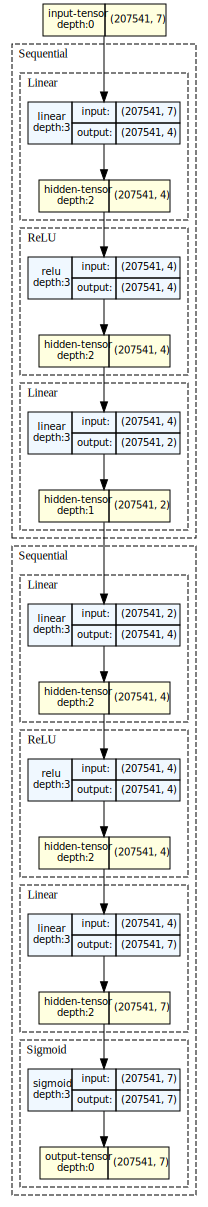

In [26]:
# Plot the model
# https://stackoverflow.com/questions/52468956/how-do-i-visualize-a-net-in-pytorch
model_graph = draw_graph(model=autoencoder, input_data=df_normal, graph_name='torch_autoencoder', \
                         expand_nested=True, save_graph=False,show_shapes=True, graph_dir='TB', \
                            roll=True, hide_inner_tensors=False, hide_module_functions=False)
model_graph.visual_graph

In [27]:
# Get the autoencoder state dictionary
# This gives the parameters, i.e. weights and bias at each layer
autoencoder.state_dict()

OrderedDict([('encoder.0.weight',
              tensor([[-0.0014, -0.1363, -0.1004, -0.3377,  0.2486,  0.1157,  0.0314],
                      [ 0.2840, -0.1487, -0.2395,  0.0627,  0.0953,  0.1672,  0.0525],
                      [ 0.0292, -0.2478,  0.1350,  0.0882,  0.2794, -0.0681, -0.3362],
                      [-0.1962, -0.0873,  0.3333,  0.2471, -0.3320, -0.2212, -0.1602]])),
             ('encoder.0.bias', tensor([-0.2164, -0.3717, -0.2159, -0.2907])),
             ('encoder.2.weight',
              tensor([[ 0.3254,  0.3865,  0.1229, -0.0371],
                      [ 0.1801,  0.4485, -0.0020, -0.2743]])),
             ('encoder.2.bias', tensor([-0.1732,  0.0544])),
             ('decoder.0.weight',
              tensor([[ 0.2567,  0.3076],
                      [-0.2819, -0.5945],
                      [ 0.1979,  0.4160],
                      [-0.3773, -0.6499]])),
             ('decoder.0.bias', tensor([ 0.3554, -0.3273, -0.2440,  0.1109])),
             ('decoder.2.weight',


In [28]:
# If we wanted to get one specific layer, in this case, the weight and shape of our first layer
autoencoder.state_dict()['encoder.0.weight'], autoencoder.state_dict()['encoder.0.weight'].shape

(tensor([[-0.0014, -0.1363, -0.1004, -0.3377,  0.2486,  0.1157,  0.0314],
         [ 0.2840, -0.1487, -0.2395,  0.0627,  0.0953,  0.1672,  0.0525],
         [ 0.0292, -0.2478,  0.1350,  0.0882,  0.2794, -0.0681, -0.3362],
         [-0.1962, -0.0873,  0.3333,  0.2471, -0.3320, -0.2212, -0.1602]]),
 torch.Size([4, 7]))

In [29]:
# Similarly, we can get the bias via
autoencoder.state_dict()['encoder.0.bias'], autoencoder.state_dict()['encoder.0.weight'].shape

(tensor([-0.2164, -0.3717, -0.2159, -0.2907]), torch.Size([4, 7]))

In [30]:
# Define the objective function 
# As in the tensorflow autoencoder notebook
#   12. Beginning Basic Deep Learning - Anomaly Detection with AutoEncoders, Tensorflow
# I will use Mean Absolute Error (MAE)
#   https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html
mae_loss_fn = torch.nn.L1Loss(reduction='mean')
mae_loss_fn

L1Loss()

In [31]:
# Define an optimizer
#   https://pytorch.org/docs/stable/optim.html
# Reusing the Adam optimizer with the same learning rate as was done in the tensorflow autoencoder notebook
#   12. Beginning Basic Deep Learning - Anomaly Detection with AutoEncoders, Tensorflow
optimizer = torch.optim.Adam(params=autoencoder.parameters(), lr=0.01)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [32]:
# Time to train the model
# Define the number of epochs
#   https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

EPOCHS = 300
TRAINNG_LOSS = []

# Setup the training loop
for epoch in range(EPOCHS):
    # Turn on gradient tracking 
    autoencoder.train(True)

    # Zero out the gradients
    optimizer.zero_grad()

    # make predictions
    y_pred = autoencoder(df_normal)
    # print(y_pred)

    # With the predictions in place calculate the loss
    loss = mae_loss_fn(y_pred, df_normal)
    TRAINNG_LOSS.append(loss.mean())

    # Calculate the gradients
    loss.backward()

    # Adjust the learned weights
    optimizer.step()

    if epoch %10 == 0: 
        print(f'Epoch: {epoch} : Loss: {loss}')

Epoch: 0 : Loss: 0.5094569325447083
Epoch: 10 : Loss: 0.4729147255420685
Epoch: 20 : Loss: 0.428600937128067
Epoch: 30 : Loss: 0.37137508392333984
Epoch: 40 : Loss: 0.29655909538269043
Epoch: 50 : Loss: 0.1994057148694992
Epoch: 60 : Loss: 0.10585106164216995
Epoch: 70 : Loss: 0.044996477663517
Epoch: 80 : Loss: 0.0173978079110384
Epoch: 90 : Loss: 0.007569702807813883
Epoch: 100 : Loss: 0.00411306694149971
Epoch: 110 : Loss: 0.0027139722369611263
Epoch: 120 : Loss: 0.002030372153967619
Epoch: 130 : Loss: 0.0016359413275495172
Epoch: 140 : Loss: 0.001376876956783235
Epoch: 150 : Loss: 0.0011904549319297075
Epoch: 160 : Loss: 0.001048307865858078
Epoch: 170 : Loss: 0.0009360666153952479
Epoch: 180 : Loss: 0.0008450598688796163
Epoch: 190 : Loss: 0.0007696144166402519
Epoch: 200 : Loss: 0.0007061254582367837
Epoch: 210 : Loss: 0.0006520535098388791
Epoch: 220 : Loss: 0.0006055600242689252
Epoch: 230 : Loss: 0.0005652551772072911
Epoch: 240 : Loss: 0.000530094257555902
Epoch: 250 : Loss: 

In [33]:
# What does the learned parameters look like?
# Let's get those
list(autoencoder.eval().parameters())

[Parameter containing:
 tensor([[-0.0014, -0.1363, -0.1004, -0.3377,  0.2486,  0.1157,  0.0314],
         [ 0.2840, -0.1487, -0.2395,  0.0627,  0.0953,  0.1672,  0.0525],
         [ 0.0292, -0.2478,  0.1350,  0.0882,  0.2794, -0.0681, -0.3362],
         [-0.1976,  0.1418,  0.2132,  0.2469, -0.3320, -0.2213, -0.1602]],
        requires_grad=True),
 Parameter containing:
 tensor([-0.2164, -0.3717, -0.2159, -0.4705], requires_grad=True),
 Parameter containing:
 tensor([[ 0.3254,  0.3865,  0.1229, -0.0180],
         [ 0.1801,  0.4485, -0.0020, -0.2281]], requires_grad=True),
 Parameter containing:
 tensor([1.1712, 1.2629], requires_grad=True),
 Parameter containing:
 tensor([[ 1.1317,  1.4114],
         [-0.2819, -0.5945],
         [ 1.2616,  1.3800],
         [-0.2687, -0.7604]], requires_grad=True),
 Parameter containing:
 tensor([ 1.2607, -0.3273,  0.5508,  0.0013], requires_grad=True),
 Parameter containing:
 tensor([[-0.6961, -0.3803, -0.9264, -0.0068],
         [-1.2101, -0.4147, -0.

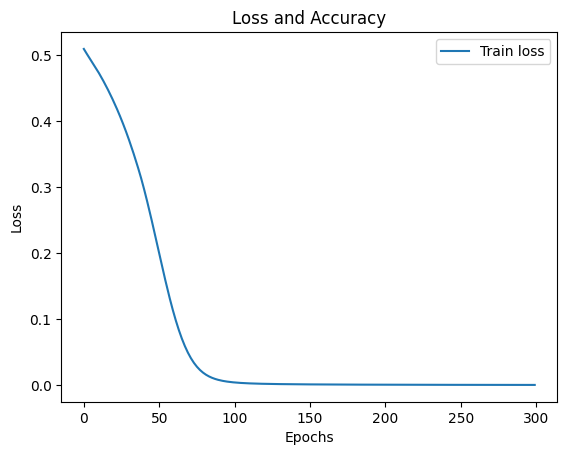

In [34]:
# plot the training & validation loss and accuracy
#   05 - Beginning Matplotlib
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.legend.html
# We can see from below the loss has decreased while the accuracy has increased.
# More importantly, the graphs confirm that 4 epochs is probably enough 
# for this algorithm, based on the learning rate we choose
plt.title('Loss and Accuracy')
plt.plot(range(len(TRAINNG_LOSS)), torch.tensor(TRAINNG_LOSS).detach().numpy() )
plt.legend(labels=['Train loss', 'Validation loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

In [35]:
# The encoded data is now down from its original 7 features to  2. 
# This represents the bottleneck/latent space. Also represented by "z"
# Also called the latent space
with torch.inference_mode():
    normal_encoded_data = autoencoder.encoder(df_normal)
normal_encoded_data

tensor([[1.1712, 1.2629],
        [1.1712, 1.2629],
        [1.1712, 1.2629],
        ...,
        [1.1712, 1.2629],
        [1.1712, 1.2629],
        [1.1712, 1.2629]])

In [36]:
# Get the shape of this latent space
# We see we have the same number of samples as the training data but now 2 dimensions rather than the original 7
normal_encoded_data.shape, df_normal.shape

(torch.Size([207541, 2]), torch.Size([207541, 7]))

In the notebook on PCA - <br>
&emsp;&emsp;  07 - Beginning Principal Component Analysis (PCA) <br>
We did dimensionality reduction. Think of above as the same, as we moved from 7 dimensions to 2, <br>
the main difference is in this autoencoder approach, we are using non-linear transformation.  <br>
Normal linear equation is f(x) = wx+b  <br>

Our non-linear transformation is f(x) = relu(wx+b) <br>
By applying the activation function (relu in this case) to wx+b, the result is made non-linear

In [37]:
# Reconstructing the data from the encoded data
np.set_printoptions(suppress=True)

with torch.inference_mode():
    normal_decoded_data = autoencoder.decoder(normal_encoded_data)
normal_decoded_data

tensor([[5.5208e-04, 7.5782e-05, 4.1552e-05,  ..., 8.1084e-04, 8.5016e-05,
         1.4195e-04],
        [5.5208e-04, 7.5782e-05, 4.1552e-05,  ..., 8.1084e-04, 8.5016e-05,
         1.4195e-04],
        [5.5208e-04, 7.5782e-05, 4.1552e-05,  ..., 8.1084e-04, 8.5016e-05,
         1.4195e-04],
        ...,
        [5.5208e-04, 7.5782e-05, 4.1552e-05,  ..., 8.1084e-04, 8.5016e-05,
         1.4195e-04],
        [5.5208e-04, 7.5782e-05, 4.1552e-05,  ..., 8.1084e-04, 8.5016e-05,
         1.4195e-04],
        [5.5208e-04, 7.5782e-05, 4.1552e-05,  ..., 8.1084e-04, 8.5016e-05,
         1.4195e-04]])

In [38]:
# Get the shape of the decoded data
# We can see, we now have the same number of records and dimensions from the decoded data
normal_decoded_data.shape, df_normal.shape

(torch.Size([207541, 7]), torch.Size([207541, 7]))

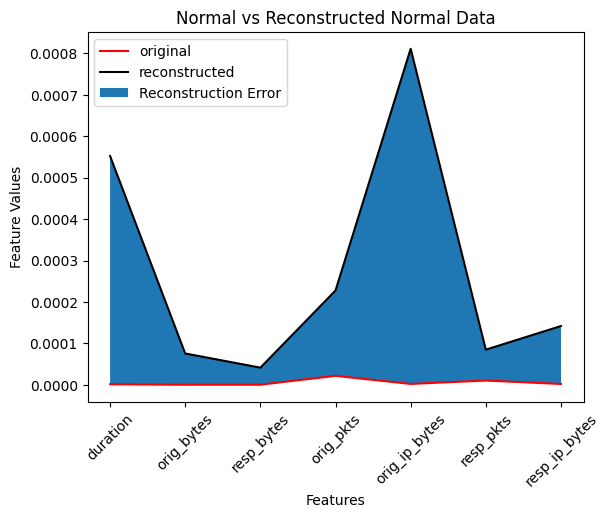

In [39]:
# Getting the reconstructing error by comparing the normal data with reconstructed normal data
plt.title('Normal vs Reconstructed Normal Data')
plt.plot(df_normal[0, : ], 'r', normal_decoded_data[0, : ], 'k')
plt.fill_between(np.arange(start=0, stop=7, step=1), df_normal[0, : ],normal_decoded_data[0, : ])
plt.xlabel('Features')
plt.xticks(np.arange(start=0, stop=7, step=1), ['duration', 'orig_bytes', 'resp_bytes', 
                                                'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes'], rotation=45)
plt.ylabel(ylabel='Feature Values')
plt.legend(labels=['original', 'reconstructed', 'Reconstruction Error'])
plt.show()

In [40]:
# Encode the suspicious data
with torch.inference_mode():
    suspicious_encoded_data = autoencoder.encoder(df_suspicious)

# Get a view of the latent space
suspicious_encoded_data

tensor([[1.1712, 1.2629],
        [1.1712, 1.2629],
        [1.1712, 1.2629],
        [1.1712, 1.2629],
        [1.1712, 1.2629],
        [1.1712, 1.2629],
        [1.1712, 1.2629],
        [1.1712, 1.2629],
        [1.1712, 1.2629],
        [1.1712, 1.2629],
        [1.1712, 1.2629],
        [1.1712, 1.2629],
        [1.1712, 1.2629],
        [1.1712, 1.2629],
        [1.1712, 1.2629],
        [1.1712, 1.2629],
        [1.1712, 1.2629],
        [1.1712, 1.2629],
        [1.1712, 1.2629],
        [1.1712, 1.2629],
        [1.1712, 1.2629],
        [1.1712, 1.2629],
        [1.1712, 1.2629],
        [1.1712, 1.2629],
        [1.1712, 1.2629],
        [1.1712, 1.2629],
        [1.1712, 1.2629],
        [1.1712, 1.2629],
        [1.1712, 1.2629],
        [1.1712, 1.2629],
        [1.1712, 1.2629],
        [1.1712, 1.2629],
        [1.1712, 1.2629],
        [1.1712, 1.2629],
        [1.1712, 1.2629],
        [1.1712, 1.2629],
        [1.1712, 1.2629],
        [1.1712, 1.2629],
        [1.1

In [41]:
# Decode the encoded suspicious data 
np.set_printoptions(suppress=True)
with torch.inference_mode():
    suspicious_decoded_data = autoencoder.decoder(suspicious_encoded_data)
suspicious_decoded_data

tensor([[5.5208e-04, 7.5782e-05, 4.1552e-05, 2.2772e-04, 8.1084e-04, 8.5016e-05,
         1.4195e-04],
        [5.5208e-04, 7.5782e-05, 4.1552e-05, 2.2772e-04, 8.1084e-04, 8.5016e-05,
         1.4195e-04],
        [5.5208e-04, 7.5782e-05, 4.1552e-05, 2.2772e-04, 8.1084e-04, 8.5016e-05,
         1.4195e-04],
        [5.5208e-04, 7.5782e-05, 4.1552e-05, 2.2772e-04, 8.1084e-04, 8.5016e-05,
         1.4195e-04],
        [5.5208e-04, 7.5782e-05, 4.1552e-05, 2.2772e-04, 8.1084e-04, 8.5016e-05,
         1.4195e-04],
        [5.5208e-04, 7.5782e-05, 4.1552e-05, 2.2772e-04, 8.1084e-04, 8.5016e-05,
         1.4195e-04],
        [5.5208e-04, 7.5782e-05, 4.1552e-05, 2.2772e-04, 8.1084e-04, 8.5016e-05,
         1.4195e-04],
        [5.5208e-04, 7.5782e-05, 4.1552e-05, 2.2772e-04, 8.1084e-04, 8.5016e-05,
         1.4195e-04],
        [5.5208e-04, 7.5782e-05, 4.1552e-05, 2.2772e-04, 8.1084e-04, 8.5016e-05,
         1.4195e-04],
        [5.5208e-04, 7.5782e-05, 4.1552e-05, 2.2772e-04, 8.1084e-04, 8.50

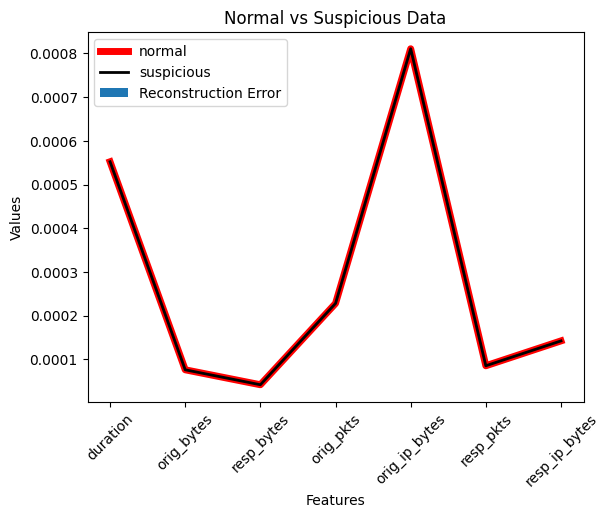

In [42]:
# Plot the reconstructing error of the normal decoded data with reconstructed suspicious data
plt.title('Normal vs Suspicious Data')
plt.plot(normal_decoded_data[5, : ], 'r', lw=5)
plt.plot(suspicious_decoded_data[5, : ], 'k', lw=2)
plt.fill_between(np.arange(start=0, stop=7, step=1), normal_decoded_data[0, : ], suspicious_decoded_data[0, : ])
plt.ylabel('Values')
plt.xlabel('Features')
plt.xticks(np.arange(start=0, stop=7, step=1), ['duration', 'orig_bytes', 
                                                'resp_bytes', 'orig_pkts', 'orig_ip_bytes', 
                                                'resp_pkts', 'resp_ip_bytes'], rotation=45)
plt.legend(labels=['normal', 'suspicious', 'Reconstruction Error'])
plt.show()

In [43]:
# Looking at the entire dataset to see what the errors look like
# Note I'm excluding the labels
# First store the predictions
df_conn_as_tensor = torch.tensor(df_conn.drop(columns=['label'], inplace=False).values, dtype=torch.float)
with torch.inference_mode():
    predictions = autoencoder(df_conn_as_tensor)
predictions

tensor([[5.9923e-24, 1.7863e-31, 1.0557e-33,  ..., 1.1512e-22, 4.2442e-32,
         1.3153e-28],
        [0.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 1.0000e+00, 0.0000e+00,
         0.0000e+00],
        [6.4400e-24, 1.9665e-31, 1.1704e-33,  ..., 1.2322e-22, 4.6837e-32,
         1.4345e-28],
        ...,
        [5.7735e-06, 1.7055e-07, 5.9636e-08,  ..., 1.0863e-05, 1.6580e-07,
         5.9133e-07],
        [5.7735e-06, 1.7055e-07, 5.9636e-08,  ..., 1.0863e-05, 1.6580e-07,
         5.9133e-07],
        [5.7735e-06, 1.7055e-07, 5.9636e-08,  ..., 1.0863e-05, 1.6580e-07,
         5.9133e-07]])

In [44]:
# Redefine the loss function, this time using reduction = "none"
# This is because I don't want to find the loss on the entire dataset
# But instead on each sample
mae_loss_fn = torch.nn.L1Loss(reduction='none')
mae_loss_fn

L1Loss()

In [45]:
# Getting the MAE Error of the entire dataset but for each sample across dimension = 1
# Get the mean across dimension 1
errors_mae = torch.mean(mae_loss_fn(predictions, df_conn_as_tensor), dim=1)
errors_mae

tensor([4.3144e+02, 1.3494e+05, 4.3172e+02,  ..., 5.8571e+00, 5.8571e+00,
        5.8571e+00])

In [46]:
# Turn off scientific notation for the dataframe
pd.set_option.float_format = '{:.2f}'.format

# Let's now create a dataframe consisting of the reconstruction error and the labels
# The idea is to see how the errors look for anomalies vs normal data
df_errors = pd.DataFrame({'errors_mae':errors_mae, 'label': df_conn.label})
df_errors

,errors_mae,label
5,431.44,0
6,134935.05,0
7,431.72,0
8,167047.50,0
9,83734.32,0
...,...,...
4430183,13.43,0
4430184,5.86,0
4430185,5.86,0
4430186,5.86,0


In [47]:
# Create a new dataframe of the reconstruction error of the normal samples
df_normal_reconstructed = df_errors[df_errors.label == 0]
df_normal_reconstructed

,errors_mae,label
5,431.44,0
6,134935.05,0
7,431.72,0
8,167047.50,0
9,83734.32,0
...,...,...
4430183,13.43,0
4430184,5.86,0
4430185,5.86,0
4430186,5.86,0


In [48]:
# Create a new dataframe of the reconstruction error of the suspicious samples
df_suspicious_reconstructed = df_errors[df_errors.label == 1]
df_suspicious_reconstructed

,errors_mae,label
5982,3971518.00,1
51574,242973.11,1
55611,467516.94,1
115226,662248.00,1
115972,1239710.38,1
...,...,...
4032886,290324.97,1
4052768,359433.22,1
4070183,479295.91,1
4192109,207732.22,1


In [49]:
# Describe the suspicious data
df_suspicious_reconstructed.describe()

,errors_mae,label
count,67.00,67.00
mean,8049012.50,1.00
std,37969652.00,0.00
min,207732.22,1.00
25%,372843.22,1.00
50%,662248.00,1.00
75%,1252358.06,1.00
max,268924736.00,1.00


In [50]:
# Get the statistics on the normal reconstructed data
df_normal_reconstructed.describe()

,errors_mae,label
count,207541.00,207541.00
mean,54963.20,0.00
std,2345637.25,0.00
min,4.14,0.00
25%,13.43,0.00
50%,23.15,0.00
75%,217.58,0.00
max,334820192.00,0.00


In [51]:
# We can see clearly from above, the reconstruction errors for the suspicious traffic is 
# significantly higher when compared to the normal traffic

In [52]:
# Find the index location of that record where the highest value exists in the suspicious dataframe
np.where(df_suspicious_reconstructed.values == df_suspicious_reconstructed.values.max())

(array([47], dtype=int64), array([0], dtype=int64))

In [53]:
# Get the value of the record at that index position
df_suspicious[47]

tensor([9.1878e-06, 3.2633e+00, 1.4863e-05, 3.6407e-05, 4.6834e-06, 5.4254e-05,
        4.8458e-05])

In [54]:
# Keep in mind though, abov represents the previous scaled data
# Inverting the scaling process
min_max_scaler.inverse_transform(df_suspicious[47].reshape(1, -1))

array([[3.06013998e-01, 1.88241288e+09, 3.11830005e+04, 9.99999966e+00,
        1.05500004e+03, 3.10000004e+01, 2.80510009e+04]])

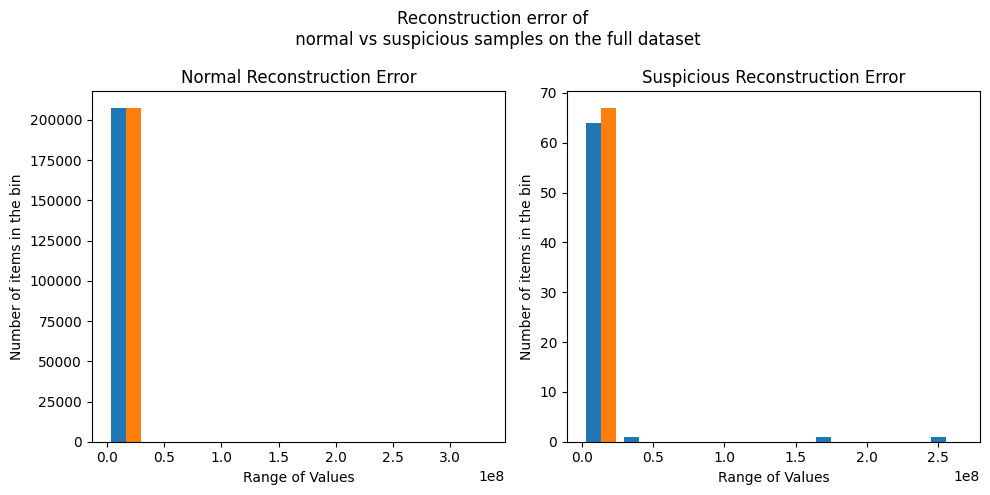

In [55]:
# Plot histograms of the normal and suspicious reconstruction error
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,5))

plt.suptitle('Reconstruction error of \n normal vs suspicious samples on the full dataset')
ax[0].hist(df_normal_reconstructed, bins=10)
ax[0].set_title('Normal Reconstruction Error')
ax[0].set_xlabel('Range of Values')
ax[0].set_ylabel('Number of items in the bin')

ax[1].hist(df_suspicious_reconstructed, bins=10)
ax[1].set_title('Suspicious Reconstruction Error')
ax[1].set_xlabel('Range of Values')
ax[1].set_ylabel('Number of items in the bin')
plt.tight_layout()

plt.show()

In [56]:
# Defining a reconstruction error threshold that can help us discriminate between normal and suspicious activity
# Keep in mind, your domain knowledge comes heavily into play here.
# Set the threshold too low and you get a number of false positives
# Set the threshold too high and you get false negatives
# This is a game of give and take. 
# What are you willing to give and what are you willing to take?
# My recommendation,be ready to accept false positives rather than false negatives
# Mine is set to one standard deviation above the mean
threshold = df_normal_reconstructed.errors_mae.mean() + df_normal_reconstructed.errors_mae.std()
threshold

2400600.5

In [57]:
# We've done a lot so far. But how is the model performing

# Get the reconstruction error of the entire dataset
with torch.inference_mode():
    reconstruction_error = autoencoder(df_conn_as_tensor)

# Get the loss
reconstruction_loss = torch.mean(mae_loss_fn(df_conn_as_tensor, reconstruction_error ), dim=1)
#reconstruction_loss

# Calculate if the values in our reconstruction loss is less than our threshold
# https://pytorch.org/docs/stable/generated/torch.less.html
loss_less_threshold = torch.less(input=reconstruction_loss, other=threshold)
loss_less_threshold

tensor([True, True, True,  ..., True, True, True])

In [58]:
# Get the shape of the two arrays
df_conn_as_tensor.shape, df_normal_labels.shape, loss_less_threshold

(torch.Size([207608, 7]),
 (207541,),
 tensor([True, True, True,  ..., True, True, True]))

In [59]:
# Get a count of the values
np.unique(loss_less_threshold.numpy().astype('int'), return_counts=True)

(array([0, 1]), array([   115, 207493], dtype=int64))

In [60]:
# How did our model do for training
# import some metrics
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, \
    precision_recall_curve, auc, classification_report, roc_curve

In [61]:
# Get the accuracy score. 
# Keep in mind, the problem we are solving here is not a classification problem
# note these values are terrible. However, this is of little concern to me at this time
# Why? Because this is for learning purpose, not prediction
# Besides, "All models are wrong, some are useful"
# https://en.wikipedia.org/wiki/All_models_are_wrong
# Maybe along the way we will find an algorithm that allows us to build a useful model
accuracy_score(y_true=df_errors.label, y_pred=loss_less_threshold)

0.0007706832106662557

In [62]:
# Get the True and false positive rate along with the threshold
# https://venelinvalkov.medium.com/credit-card-fraud-detection-using-autoencoders-in-keras-tensorflow-for-hackers-part-vii-20e0c85301bd
false_positive_rate, true_positive_rate, thresholds =  roc_curve(y_true=df_errors.label, 
                                                                 y_score=df_errors.errors_mae)

# Get the Area Under the Curve (AUC) Score
auc(false_positive_rate, true_positive_rate)

0.9827176748460491

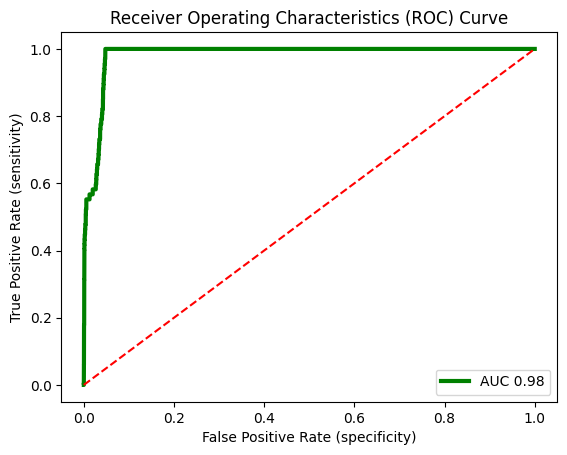

In [63]:
# Plot the Receiver Operating Characteristics (ROC) Curve
# Ths shows the true vs false positive rate across different thresholds values
# This curve does look good as it is further to the top left. 
# This is actually the type of ROC curve you want to see
# Keep in mind this is "mostly" used with binary classification. 
# This is not a binary classification problem but the ROC is being used to understand our model, not to "classify" the data
# https://www.displayr.com/what-is-a-roc-curve-how-to-interpret-it/
plt.title('Receiver Operating Characteristics (ROC) Curve')
plt.plot(false_positive_rate, true_positive_rate, lw=3, label=f'AUC {round(auc(false_positive_rate, true_positive_rate), 2)}', 
         c='g')
plt.plot([0,1], ls='--', c='r')
plt.ylabel('True Positive Rate (sensitivity)')
plt.xlabel('False Positive Rate (specificity)')
plt.legend(loc='best')
plt.show()

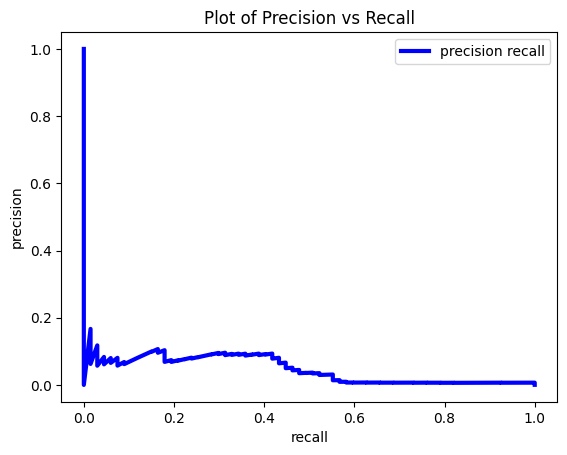

In [64]:
# Plot a precision recall curve
precison, recall, thresh = precision_recall_curve(df_errors.label, df_errors.errors_mae)
plt.title('Plot of Precision vs Recall')
plt.plot(recall, precison, 'b', lw=3, label='precision recall')
plt.xlabel('recall')
plt.ylabel('precision')
plt.legend()

Text(0, 0.5, 'Precision')

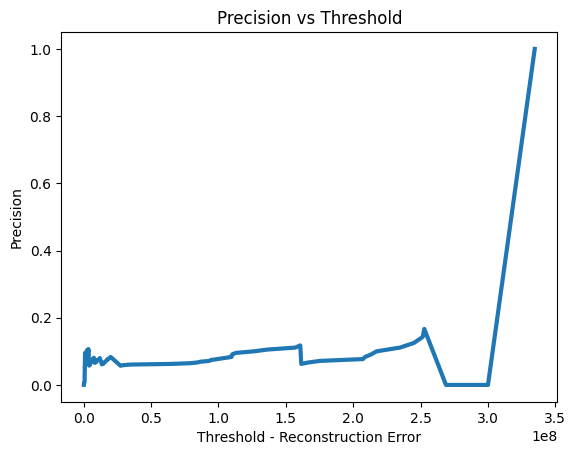

In [65]:
# Plot the precision vs thresholds
# Looks like once the reconstruction error goes to over 
plt.title('Precision vs Threshold')
plt.plot(thresh, precison[1:], lw=3, label='precision vs threshold')
plt.xlabel('Threshold - Reconstruction Error')
plt.ylabel('Precision')

In [66]:
# As the reconstruction error goes over 3e8, then is when the precision is the highest
# Finding those records where the reconstruction error is greater than 3e8 or 300000000.0
df_errors[df_errors.errors_mae > 3e8]

,errors_mae,label
3593245,300095040.00,0
3593400,334820192.00,0


Text(0, 0.5, 'Recall')

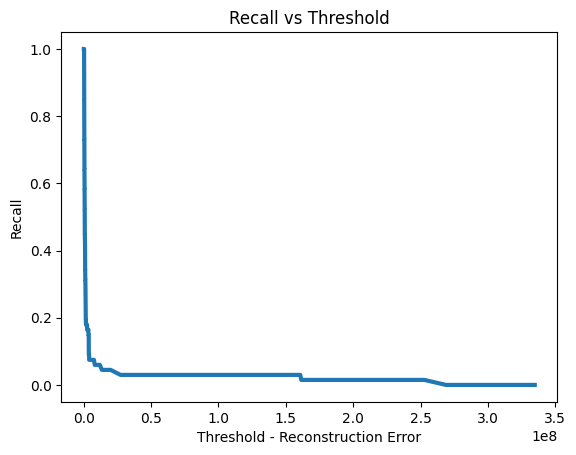

In [67]:
# only two records :-(

# Plot the recall vs thresholds
# Looks like once the reconstruction error goes to over 
plt.title('Recall vs Threshold')
plt.plot(thresh, recall[1:], lw=3, label='Recall vs threshold')
plt.xlabel('Threshold - Reconstruction Error')
plt.ylabel('Recall')

In [68]:
# As the threshold increases, the recall becomes lower. 
# This is obviously the opposite of what was seen above with the precision vs threshold

In [69]:
# Get the precision
precision_score(y_true=df_errors.label, y_pred=loss_less_threshold)

0.0002698886227487192

In [70]:
# import seaborn
# https://seaborn.pydata.org/generated/seaborn.heatmap.html
import seaborn as sns

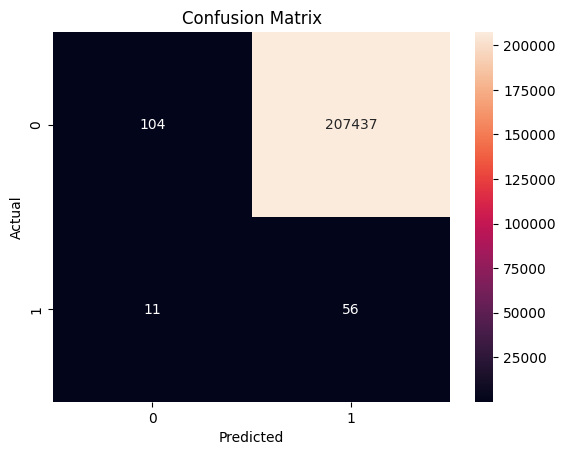

In [71]:
# Looking at the confusion matrix, clearly this model has way too much false positives
# Maybe we can do a better job at setting a different threshold
# However, as said above, we are here for learning purposes
# Most importantly, we are not attempting to solve a classification problem
# This is being used for anomaly detection
# Thus the confusion matrix is just to give us insights into what our threshold looks like at present
sns.heatmap(confusion_matrix(y_true=df_errors.label, y_pred=loss_less_threshold), annot=True, fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [72]:
# Imagine working in a SOC and you have to deal with all these false positives. 
# My gosh, this would make our job so much harder

# If you wish to understand these metrics more, see
#   10. Beginning Supervise Learning - Machine Learning - Logistic Regression, Decision Trees and Metrics

# Thankfully this is not a classification problem we are trying to solve. 
# if it was, these outputs are really ... well want for a better word ... terrible
print(classification_report(y_true=df_errors.label, y_pred=loss_less_threshold))

              precision    recall  f1-score   support

           0       0.90      0.00      0.00    207541
           1       0.00      0.84      0.00        67

    accuracy                           0.00    207608
   macro avg       0.45      0.42      0.00    207608
weighted avg       0.90      0.00      0.00    207608



In [73]:
# With the threshold define, let's say a record comes in with the following values
# Let's define a sample with the features values: 
# duration	orig_bytes	resp_bytes	orig_pkts	orig_ip_bytes	resp_pkts	resp_ip_bytes
new_sample = torch.tensor([[141., 356138566,	11037090, 60, 3026679, 33, 982584]], dtype=float)
new_sample

tensor([[1.4100e+02, 3.5614e+08, 1.1037e+07, 6.0000e+01, 3.0267e+06, 3.3000e+01,
         9.8258e+05]], dtype=torch.float64)

In [74]:
# Make a prediction on the sample
# Remember, we need to pass the data through the similar process we did for training
# Hence, this data is being transformed
with torch.inference_mode():
    new_sample_pred = autoencoder(torch.tensor(min_max_scaler.transform(new_sample), dtype=torch.float))

#new_sample_pred
new_sample_loss = mae_loss_fn(torch.mean(new_sample_pred, dim=1), torch.mean(new_sample, dim=1))
new_sample_loss

tensor([53026450.4283], dtype=torch.float64)

In [75]:
# Import datetime library
from datetime import datetime

In [76]:
# Write some code to trigger an alert when a sample's reconstruction error passes our threshold
f'{datetime.now()} - [!] ALERT ** SUSPICIOUS ACTIVITY ** Zeek conn.log entry Threshold Exceeded' \
    if new_sample_loss > threshold  else "[**] Normal Traffic"

'2023-05-24 18:45:47.383797 - [!] ALERT ** SUSPICIOUS ACTIVITY ** Zeek conn.log entry Threshold Exceeded'

In [77]:
# Import the os library
import os

In [78]:
# As always, before, we go, let's save the model
# With the machine learning models, joblib was used
# In this case, I leverage Keras built in utilities for saving models
#   https://pytorch.org/tutorials/beginner/saving_loading_models.html
PATH = './SAVED_MODELS/PYTORCH_AUTOENCODER/'
MODELS_PATH = os.makedirs(name=PATH, exist_ok=True)

torch.save(autoencoder.state_dict(), f'{PATH}/pytorch_autoencoder.pt')

In [79]:
# With the model saved, time to load it
loaded_torch_autoencoder = AnomalyDetection()
loaded_torch_autoencoder.load_state_dict(torch.load(f'{PATH}/pytorch_autoencoder.pt'))

<All keys matched successfully>

In [80]:
# With the keys loaded successfully, place the model in eval model
loaded_torch_autoencoder.eval()

AnomalyDetection(
  (encoder): Sequential(
    (0): Linear(in_features=7, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=7, bias=True)
    (3): Sigmoid()
  )
)

In [81]:
# Make a prediction with the loaded model
loaded_prediction_mae = torch.mean(mae_loss_fn(new_sample, \
                                               loaded_torch_autoencoder(torch.tensor(min_max_scaler.transform(new_sample), \
                                                                                     dtype=torch.float))), dim=1)
loaded_prediction_mae


# Print the information as a log
f'{datetime.now()} - [!] ALERT ** SUSPICIOUS ACTIVITY ** Zeek conn.log entry Threshold Exceeded' \
    if loaded_prediction_mae > threshold  else "[**] Normal Traffic"

'2023-05-24 18:45:47.823114 - [!] ALERT ** SUSPICIOUS ACTIVITY ** Zeek conn.log entry Threshold Exceeded'

In [ ]:
# Moving on!

Additional References and good reads: <br>
https://www.tensorflow.org/tutorials/generative/autoencoder <br>
https://www.youtube.com/watch?v=2K3ScZp1dXQ <br>
https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9684419 <br>
https://www.mdpi.com/1424-8220/21/13/4294 <br>
https://ieeexplore.ieee.org/document/9647639 <br>
https://www.deeplearningbook.org/contents/autoencoders.html <br>
https://web.stanford.edu/class/cs294a/sparseAutoencoder.pdf <br>
https://www.youtube.com/watch?v=vfnxKO2rMq4 <br>
https://www.youtube.com/watch?v=wqhZaWR-J94 <br>
https://www.youtube.com/watch?v=q222maQaPYo <br>


https://learnopencv.com/autoencoder-in-tensorflow-2-beginners-guide/ <br>
https://anomagram.fastforwardlabs.com/#/ <br>
https://www.mdpi.com/1424-8220/21/19/6679 <br>
https://aws.amazon.com/blogs/machine-learning/deploying-variational-autoencoders-for-anomaly-detection-with-tensorflow-serving-on-amazon-sagemaker/ <br>
https://learnopencv.com/autoencoder-in-tensorflow-2-beginners-guide/ <br>
https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.459.3788&rep=rep1&type=pdf <br>
https://www.youtube.com/watch?v=FzS3tMl4Nsc <br>
https://www.youtube.com/watch?v=xTU79Zs4XKY <br>